In [1]:
from sqlalchemy import create_engine,text
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
db_user = ""
db_password = ""
db_host = "" 
db_port = ""  
db_name = ""

In [3]:
connection = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
engine = create_engine(connection)

In [43]:
ACE = '08|037|025%' #inserire layerid Ace
nome_ACE = 'Dozza' #inserire nome Ace

In [5]:
query_toid = text("SELECT DATE(datefrom) AS date, SUM(datavalue) AS datavalue FROM movements WHERE toid LIKE '" + ACE + "' GROUP BY date ORDER BY date;")
try:
    with engine.connect() as connection:
        chunks = pd.read_sql(query_toid, connection, chunksize=1000) 
        df_toid = pd.concat(chunks, ignore_index=True) 
    print(df_toid)
except Exception as e:
    print(f"Errore durante l'esecuzione della query: {e}")

          date  datavalue
0   2019-08-01      10241
1   2019-08-02       9752
2   2019-08-03       9188
3   2019-08-04       7757
4   2019-08-05       8431
..         ...        ...
56  2019-09-26      10703
57  2019-09-27       9880
58  2019-09-28      10000
59  2019-09-29       9900
60  2019-09-30      10096

[61 rows x 2 columns]


In [6]:
query_layerid = text("SELECT DATE(datefrom) AS date, SUM(datavalue) AS datavalue FROM movements WHERE layerid LIKE '"+ ACE +"' GROUP BY date ORDER BY date;")
try:
    with engine.connect() as connection:
        chunks = pd.read_sql(query_layerid, connection, chunksize=1000) 
        df_layerid = pd.concat(chunks, ignore_index=True) 
    print(df_layerid)
except Exception as e:
    print(f"Errore durante l'esecuzione della query: {e}")

          date  datavalue
0   2019-08-01       9502
1   2019-08-02       9219
2   2019-08-03       9720
3   2019-08-04       7329
4   2019-08-05       8667
..         ...        ...
56  2019-09-26       9620
57  2019-09-27      10370
58  2019-09-28      10513
59  2019-09-29      10295
60  2019-09-30      10151

[61 rows x 2 columns]


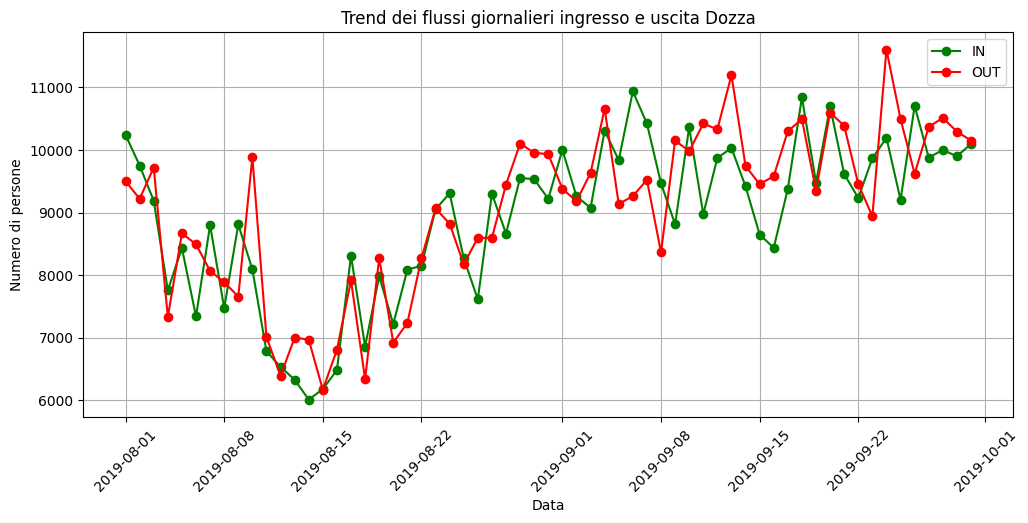

In [7]:
plt.figure(figsize=(12, 5))
plt.plot(df_toid["date"], df_toid["datavalue"], label = 'IN', marker='o', linestyle='-', color='g')
plt.plot(df_layerid["date"], df_layerid["datavalue"], label = 'OUT', marker='o', linestyle='-', color='r')
plt.xlabel("Data")
plt.ylabel("Numero di persone")
plt.title("Trend dei flussi giornalieri ingresso e uscita " + nome_ACE)
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

In [8]:
df_avg = pd.DataFrame()
df_avg['date'] = df_layerid['date']
df_avg["datavalue"] = (df_layerid["datavalue"] + df_toid["datavalue"]) / 2
print(df_avg)

          date  datavalue
0   2019-08-01     9871.5
1   2019-08-02     9485.5
2   2019-08-03     9454.0
3   2019-08-04     7543.0
4   2019-08-05     8549.0
..         ...        ...
56  2019-09-26    10161.5
57  2019-09-27    10125.0
58  2019-09-28    10256.5
59  2019-09-29    10097.5
60  2019-09-30    10123.5

[61 rows x 2 columns]


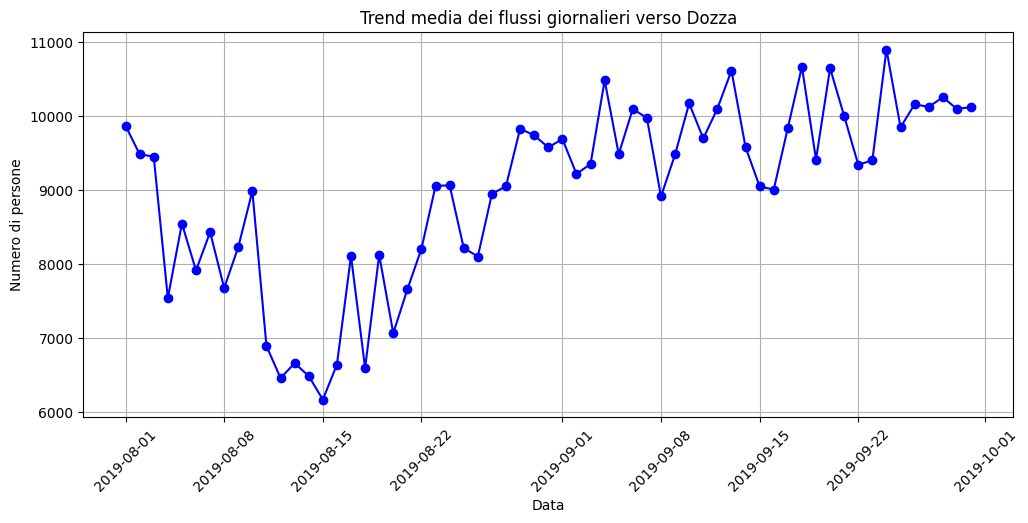

In [9]:
plt.figure(figsize=(12, 5))
plt.plot(df_avg["date"], df_avg["datavalue"], marker='o', linestyle='-', color='b')
plt.xlabel("Data")
plt.ylabel("Numero di persone")
plt.title("Trend media dei flussi giornalieri verso " + nome_ACE)
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [10]:
df_avg["date"] = pd.to_datetime(df_avg["date"], format="%Y-%m-%d")
df_avg['date_ordinal'] = df_avg['date'].map(pd.Timestamp.toordinal)

MAD: 455.65
R² Score: 0.7794
MAPE: 5.34%


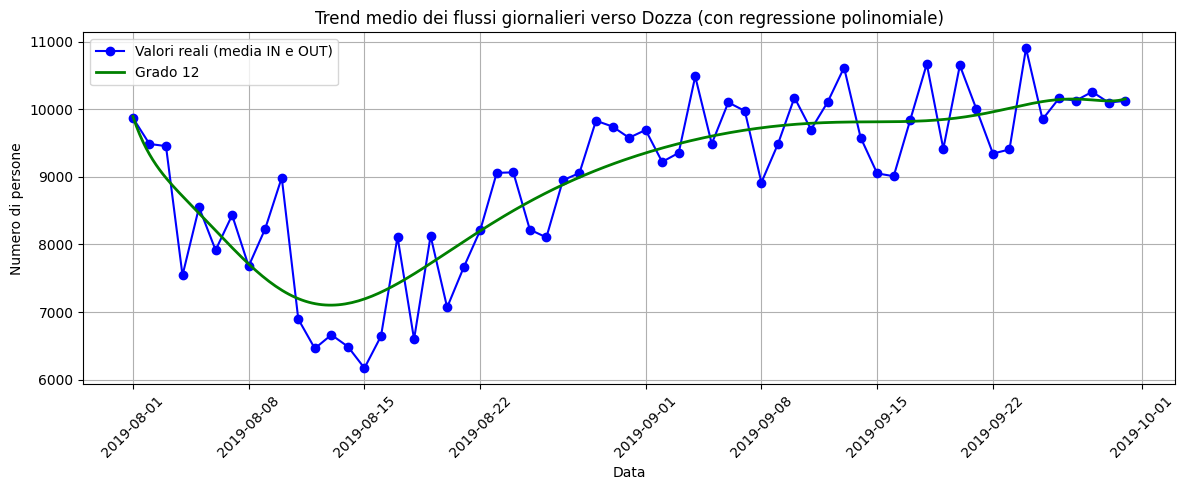

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X = df_avg["date_ordinal"].values.reshape(-1, 1)
y = df_avg["datavalue"].values

# Modello
grado = 12
model = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=grado),
    Ridge(alpha=1.0)
)

# Fit
model.fit(X, y)


X_fit = np.linspace(X.min(), X.max(), 300).reshape(-1, 1).astype(float)
y_fit = model.predict(X_fit)

# Converti X_fit in date leggibili
ordinal_to_unix_offset = datetime(1970, 1, 1).toordinal()
date_fit = pd.to_datetime(X_fit.flatten() - ordinal_to_unix_offset, unit='D', origin='unix')

#Calcolo errori
y_true = df_avg['datavalue'].values
y_pred = model.predict(X)


mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-8, y_true))) * 100
r2 = r2_score(y_true, y_pred)
errors = y_true - y_pred
mad = np.mean(np.abs(errors - np.mean(errors)))

print(f"MAD: {mad:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

# Plot
plt.figure(figsize=(12, 5))
plt.plot(df_avg['date'], df_avg['datavalue'], marker='o', linestyle='-', color='b', label='Valori reali (media IN e OUT)')
plt.plot(date_fit, y_fit, 'g-', linewidth=2, label=f'Grado {grado}')
plt.xlabel("Data")
plt.ylabel("Numero di persone")
plt.title("Trend medio dei flussi giornalieri verso " + nome_ACE + " (con regressione polinomiale)")
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()